In [13]:
import torch
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import random_split
sys.path.append(os.path.join(os.getcwd(), 'src'))

import model
import train_loop
import data_loader
import visual

In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data")
TARGET_DATA_DIR = os.path.join(DATA_DIR, "target")
LIVECELL_IMG_DIR = os.path.join(DATA_DIR, "livecell", "images")
LIVECELL_MASK_DIR = os.path.join(DATA_DIR, "livecell", "masks")
dataset = data_loader.MaskedDataset(LIVECELL_IMG_DIR, LIVECELL_MASK_DIR, length=None, in_memory=False)

Reading data into memory...


100%|██████████| 50/50 [00:01<00:00, 44.99it/s]

Dataset initialized!


In [16]:
seed = 123
test_percent = 0.001
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_test
train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(123))


50
5


In [ ]:
neural_net = model.Unet(numChannels=1, classes=2, dropout = 0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neural_net.to(device=device)
neural_net.train()

In [ ]:
train_loop.train_net(   net=neural_net,
                        dataset = train_set,
                        epochs= 1,              # Set epochs
                        batch_size= 2,          # Batch size
                        learning_rate=0.001,    # Learning rate
                        device=device,
                        val_percent=0.1,        # Percent of test set
                        save_checkpoint = True,
                        amp=False)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = model.Unet(numChannels=1, classes=2, dropout = 0.1)
PATH = "C:\\Users\\Antti\\Documents\\#1_Masters_studies\\LST_project\\models\\model_2022-02-28\\checkpoint_epoch3_2022-02-28.pth"

In [18]:
net = torch.load(PATH, map_location=device)

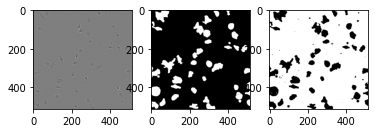

In [10]:
visual.imshow_side_by_side_model(7, dataset, net)

In [19]:
with torch.no_grad():
      image, mask = test_set[0]
      prediction = net(torch.unsqueeze(image, dim=0))
      prediction = torch.squeeze(prediction, dim=0)

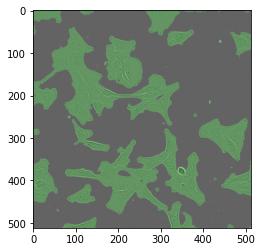

In [20]:
plt.imshow(torch.squeeze(image), cmap = 'gray')
mask_np = np.delete(prediction.permute(1,2,0).numpy(),0, axis=2)

mask_np = np.where(mask_np == 0, np.array([0,0,0]), mask_np)
mask_np = np.where(mask_np == 1, np.array([0,1,0]), mask_np)
plt.imshow(mask_np, alpha = 0.2)

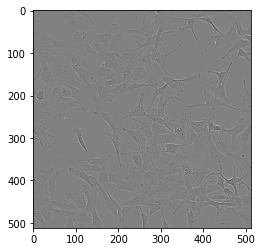

In [9]:
plt.imshow(torch.squeeze(image), cmap = 'gray')